<a href="https://colab.research.google.com/github/mhazary/agitation-unsupervised/blob/main/feature_extraction_and_exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Step 0: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Read a sample file Header
import pandas as pd

sample_path =  '/content/drive/My Drive/Agitation_Detection_Project/temp_csvs/Participant1_Day1.csv'

df = pd.read_csv(sample_path)
print(df.head())

                 timestamp  eda      accx      accy      accz    bvp  \
0  1900-01-01 10:05:00.000  0.0 -0.031266  0.984884  0.078165  -6.29   
1  1900-01-01 10:05:00.016  0.0 -0.031234  0.982652  0.078085   2.06   
2  1900-01-01 10:05:00.031  0.0 -0.031266  0.984884  0.078165  10.85   
3  1900-01-01 10:05:00.047  0.0 -0.031234  0.985753  0.078085  14.33   
4  1900-01-01 10:05:00.063  0.0 -0.031266  0.984884  0.078165   9.80   

        temp  label   participant                           day  day_number  
0  24.706610      0  Participant1  Participant1-Day1-struct.mat           1  
1  24.700302      0  Participant1  Participant1-Day1-struct.mat           1  
2  24.694589      0  Participant1  Participant1-Day1-struct.mat           1  
3  24.689595      0  Participant1  Participant1-Day1-struct.mat           1  
4  24.685416      0  Participant1  Participant1-Day1-struct.mat           1  


In [ ]:
! pip install antropy heartpy --quiet
! pip install tsfel --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.7 MB/s eta 0:00:00


# 🧠 STEP 1: Feature Extraction Utilities

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.signal import welch
from scipy.stats import iqr, entropy
import heartpy as hp
import traceback
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


def teager_energy(signal):
    return np.mean(signal[1:-1]**2 - signal[:-2]*signal[2:])

def compute_fft_features(signal, fs):
    signal = np.asarray(signal)  # ensure numpy array
    f, Pxx = welch(signal, fs=fs)
    entropy_val = entropy(Pxx + 1e-10)  # avoid log(0)
    dc_power = Pxx[0]
    total_power = np.sum(Pxx)
    return entropy_val, dc_power, total_power

def compute_slope(signal, time):
    if len(signal) < 2:
        return 0
    return np.polyfit(time, signal, 1)[0]



# 🧠 STEP 2: Main Feature Extraction per 1-Minute Window



In [ ]:
import warnings
from heartpy.exceptions import BadSignalWarning

def extract_features_per_window(df_win, fs=64):
    features = {}

    # --- ACC Features (use norm of x, y, z) ---
    try:
        acc_norm = np.sqrt(df_win['accx']**2 + df_win['accy']**2 + df_win['accz']**2)
        features.update({
            'acc_mean': np.mean(acc_norm),
            'acc_min': np.min(acc_norm),
            'acc_std': np.std(acc_norm),
            'acc_iqr': iqr(acc_norm),
            'acc_teager': teager_energy(acc_norm),
        })
        ent, dc, tot = compute_fft_features(acc_norm, fs)
        features.update({
            'acc_spectral_entropy': ent,
            'acc_dc_power': dc,
            'acc_total_power': tot,
        })
    except Exception as e:
        print(f"⚠️ ACC feature extraction failed at {df_win['timestamp'].iloc[0]}: {str(e)}")
        print(traceback.format_exc())
        features['acc_mean'] = features['acc_min'] = features['acc_std'] = features['acc_iqr'] = features['acc_teager'] = 0
        features['acc_spectral_entropy'] = features['acc_dc_power'] = features['acc_total_power'] = 0

    # --- EDA Features ---
    try:
        eda = df_win['eda'].values
        eda_deriv = np.diff(eda)
        features.update({
            'eda_std': np.std(eda),
            'eda_entropy': entropy(np.abs(eda_deriv) + 1e-10),
            'eda_deriv_max': np.max(eda_deriv) if len(eda_deriv) > 0 else 0,
            'eda_mode': pd.Series(eda).mode().iloc[0] if not pd.Series(eda).mode().empty else 0,
        })
        eda_peaks = np.where((eda[1:-1] > eda[:-2]) & (eda[1:-1] > eda[2:]))[0]
        features['eda_peak_count'] = len(eda_peaks)
        features['eda_area'] = np.trapezoid(eda)
    except Exception as e:
        print(f"⚠️ EDA feature extraction failed at {df_win['timestamp'].iloc[0]}: {str(e)}")
        print(traceback.format_exc())
        features['eda_std'] = features['eda_entropy'] = features['eda_deriv_max'] = features['eda_mode'] = 0
        features['eda_peak_count'] = features['eda_area'] = 0

    # --- TEMP Features ---
    try:
        temp = df_win['temp'].values
        features['temp_mean'] = np.mean(temp)
        features['temp_std'] = np.std(temp)
        features['temp_slope'] = compute_slope(temp, np.arange(len(temp)))
    except Exception as e:
        print(f"⚠️ TEMP feature extraction failed at {df_win['timestamp'].iloc[0]}: {str(e)}")
        print(traceback.format_exc())
        features['temp_mean'] = features['temp_std'] = features['temp_slope'] = 0

    # --- BVP Features ---
    try:
        bvp = df_win['bvp'].values
        features.update({
            'bvp_mean': np.mean(bvp),
            'bvp_std': np.std(bvp),
            'bvp_min': np.min(bvp),
            'bvp_max': np.max(bvp),
            'bvp_iqr': iqr(bvp)
        })
        ent, dc, tot = compute_fft_features(bvp, fs)
        features.update({
            'bvp_spectral_entropy': ent,
            'bvp_dc_power': dc,
            'bvp_total_power': tot
        })
    except Exception as e:
        print(f"⚠️ BVP feature extraction failed at {df_win['timestamp'].iloc[0]}: {str(e)}")
        print(traceback.format_exc())
        features['bvp_mean'] = features['bvp_std'] = features['bvp_min'] = features['bvp_max'] = features['bvp_iqr'] = 0
        features['bvp_spectral_entropy'] = features['bvp_dc_power'] = features['bvp_total_power'] = 0

    # --- HRV from BVP using heartpy ---
    hrv_keys = ['hrv_mean_IBI', 'hrv_rmssd', 'hrv_sdnn', 'hrv_pnn20', 'hrv_pnn50', 'hrv_lf', 'hrv_hf', 'hrv_lf_hf']
    try:
        bvp = df_win['bvp'].values
        if len(bvp) >= fs * 60:  # Ensure full window
            if np.any(np.isnan(bvp)) or np.std(bvp) < 1e-5:
                print(f"⚠️ Invalid BVP data at {df_win['timestamp'].iloc[0]}: NaN={np.any(np.isnan(bvp))}, Std={np.std(bvp)}")
                for k in hrv_keys:
                    features[k] = 0
            else:
                # Interpolate missing values
                bvp = pd.Series(bvp).interpolate(limit_direction='both').values

                # Smooth signal (simple moving average)
                window_size = 5
                bvp_smoothed = np.convolve(bvp, np.ones(window_size)/window_size, mode='same')

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=BadSignalWarning)
                    wd, m = hp.process(bvp_smoothed, sample_rate=fs)

                features.update({
                    'hrv_mean_IBI': m.get('ibi', 0),
                    'hrv_rmssd': m.get('rmssd', 0),
                    'hrv_sdnn': m.get('sdnn', 0),
                    'hrv_pnn20': m.get('pnn20', 0),
                    'hrv_pnn50': m.get('pnn50', 0),
                    'hrv_lf': m.get('lf', 0),
                    'hrv_hf': m.get('hf', 0),
                    'hrv_lf_hf': m.get('lf_hf', 0)
                })
        else:
            print(f"⚠️ BVP window too short at {df_win['timestamp'].iloc[0]}: {len(bvp)} samples")
            for k in hrv_keys:
                features[k] = 0
    except Exception as e:
        print(f"⚠️ HRV processing failed at {df_win['timestamp'].iloc[0]}: {str(e)}")
        print(traceback.format_exc())
        for k in hrv_keys:
            features[k] = 0

    return features


 # STEP 3: Process the Extracted Features

In [ ]:
def process_file_extract_features(file_path, output_dir, fs=64, window_sec=60, overlap_sec=30):
    print(f"\n📂 Processing: {file_path}")
    try:
        df = pd.read_csv(file_path, parse_dates=['timestamp'])
        df = df.sort_values('timestamp')
    except Exception as e:
        print(f"❌ Failed to load file: {file_path}, Reason: {e}")
        return

    window_samples = int(window_sec * fs)
    overlap_samples = int(overlap_sec * fs)
    step = window_samples - overlap_samples

    features_all = []

    for start in tqdm(range(0, len(df) - window_samples + 1, step), desc="Extracting windows"):
        df_win = df.iloc[start:start + window_samples]
        if df_win.shape[0] < window_samples:
            continue

        f_dict = extract_features_per_window(df_win, fs=fs)
        f_dict['start_time'] = df_win['timestamp'].iloc[0]
        f_dict['end_time'] = df_win['timestamp'].iloc[-1]
        f_dict['participant'] = df_win['participant'].iloc[0]
        f_dict['day'] = df_win['day'].iloc[0]
        f_dict['label'] = df_win['label'].mode().iloc[0] if not df_win['label'].isna().all() else np.nan
        features_all.append(f_dict)

    if features_all:
        feature_df = pd.DataFrame(features_all)
        output_file = os.path.basename(file_path).replace('.csv', '_features.csv')
        output_path = os.path.join(output_dir, output_file)
        feature_df.to_csv(output_path, index=False)
        print(f"✅ Saved features to: {output_path}")
    else:
        print("⚠️ No features extracted — nothing saved.")

# STEP 4: Test Run for a single file

In [ ]:
# Test input and output paths
import os

test_input = '/content/drive/My Drive/Agitation_Detection_Project/temp_csvs/Participant1_Day1.csv'
test_output_dir = '/content/drive/My Drive/Agitation_Detection_Project/original_features_test'
os.makedirs(test_output_dir, exist_ok=True)



In [ ]:
# # Rerun the test with logging to see what’s happening
# test_input = "/content/drive/My Drive/Agitation_Detection_Project/temp_csvs/Participant1_Day1.csv"
# test_output_dir = "/content/drive/My Drive/Agitation_Detection_Project/original_features_test"

# process_file_extract_features(test_input, test_output_dir, fs=64, window_sec=60, overlap_sec=30)


In [ ]:
# View the result
test_output_file = '/content/drive/My Drive/Agitation_Detection_Project/original_features_test/Participant1_Day1_features.csv'
test_df = pd.read_csv(test_output_file)
print("Extracted windows:", test_df.shape[0])
test_df.head()


Extracted windows: 1257


,acc_mean,acc_min,acc_std,acc_iqr,acc_teager,acc_spectral_entropy,acc_dc_power,acc_total_power,eda_std,eda_entropy,...,hrv_pnn20,hrv_pnn50,hrv_lf,hrv_hf,hrv_lf_hf,start_time,end_time,participant,day,label
0,0.992975,0.978771,0.007172,0.009973,0.0,4.162768,3.710546e-07,0.000203,0.000000,8.252967,...,0.769231,0.769231,0,0,0,1900-01-01 10:05:00,1900-01-01 10:05:59.984,Participant1,Participant1-Day1-struct.mat,0
1,1.052930,0.701794,0.157604,0.028672,0.0,3.364237,8.400830e-04,0.061131,0.001100,5.387349,...,1.000000,0.875000,0,0,0,1900-01-01 10:05:30,1900-01-01 10:06:29.984,Participant1,Participant1-Day1-struct.mat,0
2,1.061807,0.647090,0.162689,0.102047,0.0,3.385117,9.693362e-04,0.071693,0.027899,5.045691,...,0.933333,0.900000,0,0,0,1900-01-01 10:06:00,1900-01-01 10:06:59.984,Participant1,Participant1-Day1-struct.mat,0
3,1.001227,0.647090,0.061726,0.050865,0.0,3.326131,3.828354e-05,0.014431,0.038434,5.995242,...,1.000000,1.000000,0,0,0,1900-01-01 10:06:30,1900-01-01 10:07:29.984,Participant1,Participant1-Day1-struct.mat,0
4,0.994362,0.739314,0.036694,0.023087,0.0,3.535548,9.028224e-06,0.005369,0.190080,6.866268,...,1.000000,0.000000,0,0,0,1900-01-01 10:07:00,1900-01-01 10:07:59.984,Participant1,Participant1-Day1-struct.mat,0


# STEP 5: Plot the Feature Distribution

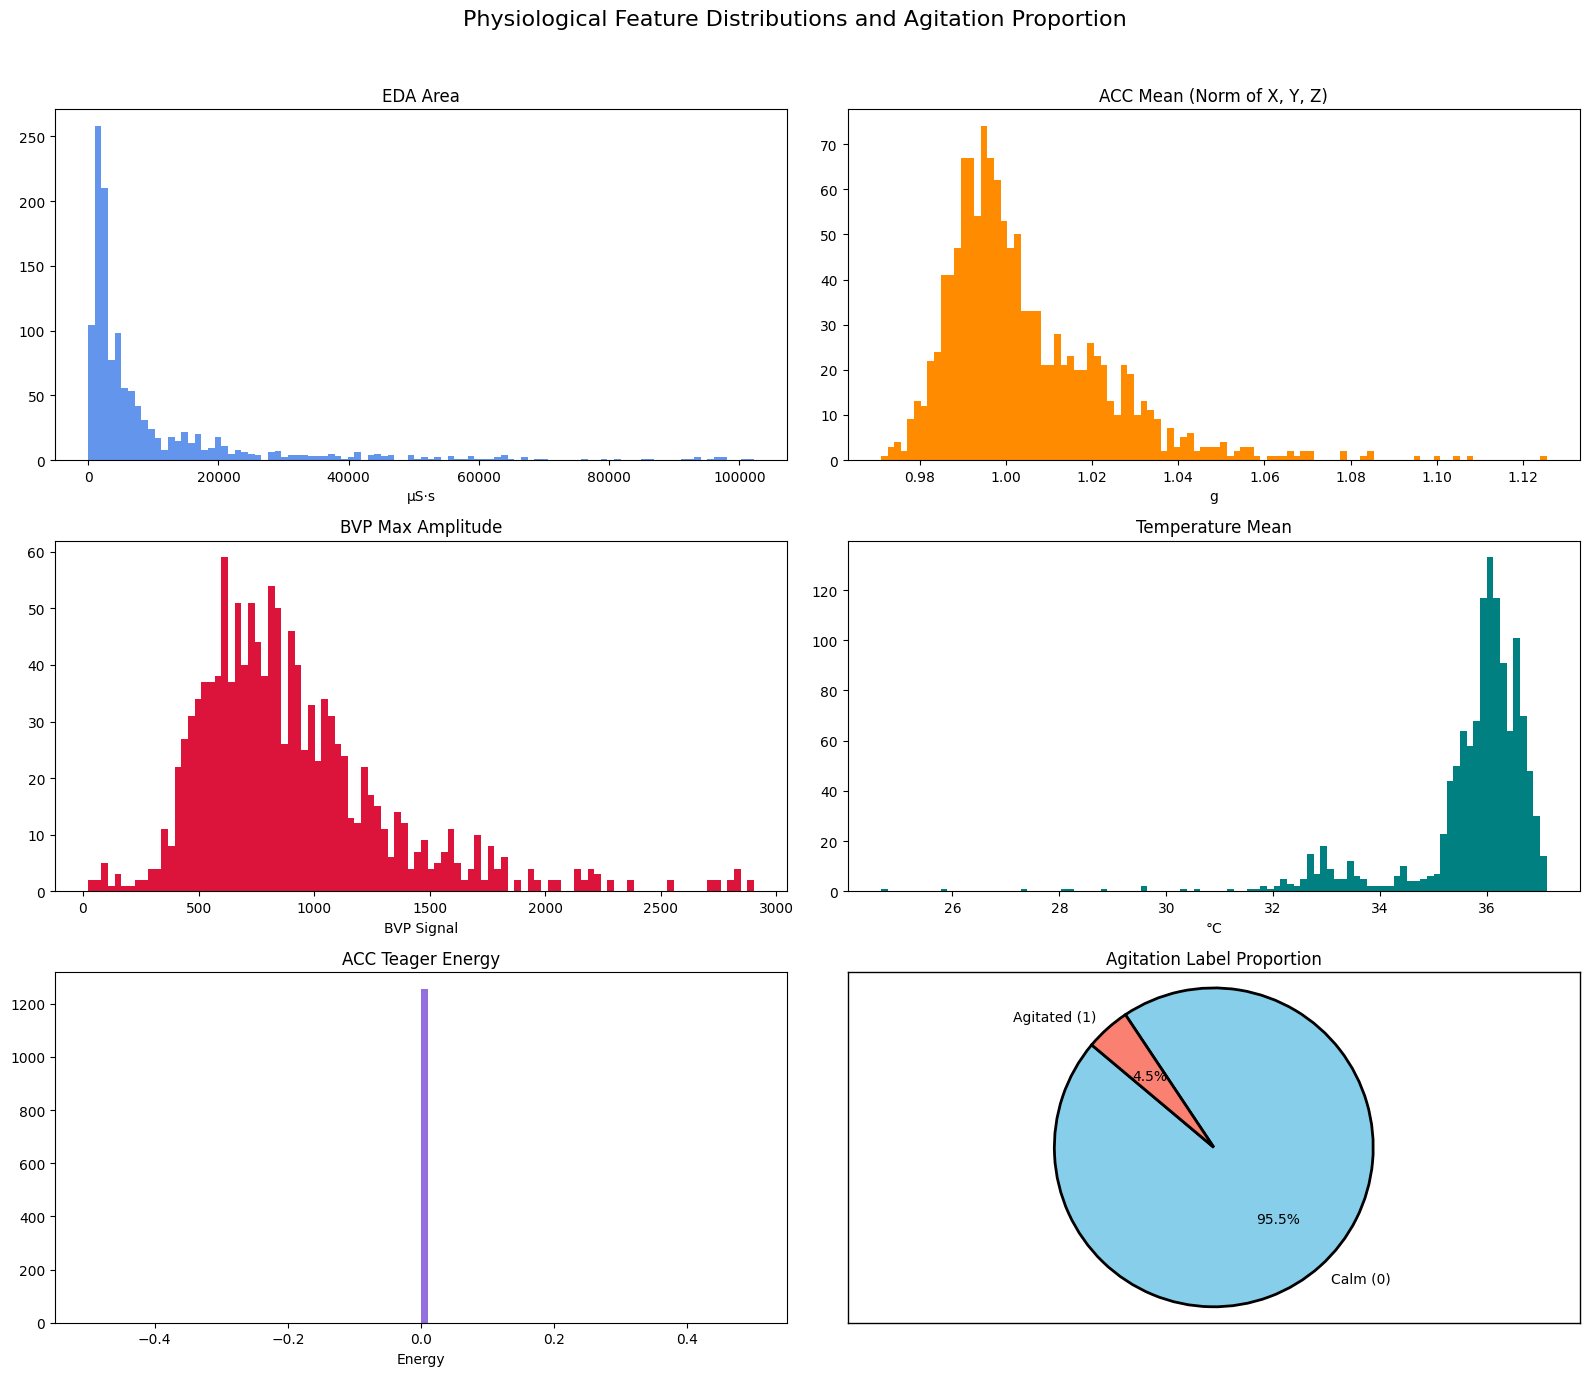

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = '/content/drive/My Drive/Agitation_Detection_Project/original_features_test/Participant1_Day1_features.csv'
df = pd.read_csv(file_path)

# Prepare label counts for pie chart
label_counts = df['label'].value_counts().sort_index()
label_labels = ['Calm (0)', 'Agitated (1)']
label_sizes = [label_counts.get(0, 0), label_counts.get(1, 0)]

# Set up 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle("Physiological Feature Distributions and Agitation Proportion", fontsize=16)

# EDA Area
axes[0, 0].hist(df['eda_area'], bins=100, color='cornflowerblue')
axes[0, 0].set_title('EDA Area')
axes[0, 0].set_xlabel('μS·s')

# ACC Mean (Norm)
axes[0, 1].hist(df['acc_mean'], bins=100, color='darkorange')
axes[0, 1].set_title('ACC Mean (Norm of X, Y, Z)')
axes[0, 1].set_xlabel('g')

# BVP Max
axes[1, 0].hist(df['bvp_max'], bins=100, color='crimson')
axes[1, 0].set_title('BVP Max Amplitude')
axes[1, 0].set_xlabel('BVP Signal')

# Temperature Mean
axes[1, 1].hist(df['temp_mean'], bins=100, color='teal')
axes[1, 1].set_title('Temperature Mean')
axes[1, 1].set_xlabel('°C')

# ACC Teager Energy
axes[2, 0].hist(df['acc_teager'], bins=100, color='mediumpurple')
axes[2, 0].set_title('ACC Teager Energy')
axes[2, 0].set_xlabel('Energy')

# Label Distribution - Pie Chart with Slice Borders and Axes Frame
colors = ['skyblue', 'salmon']
axes[2, 1].pie(
    label_sizes,
    labels=label_labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    wedgeprops={'edgecolor': 'black', 'linewidth': 2}
)
axes[2, 1].axis('equal')  # Equal aspect ratio makes the pie chart circular
axes[2, 1].set_title("Agitation Label Proportion")

# ✅ Enable frame and set border with matching linewidth
axes[2, 1].set_frame_on(True)
for spine in axes[2, 1].spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Sample Trend Analysis and Peak Detection on BVP to Detect Agitation



=== BVP Trend Analysis ===


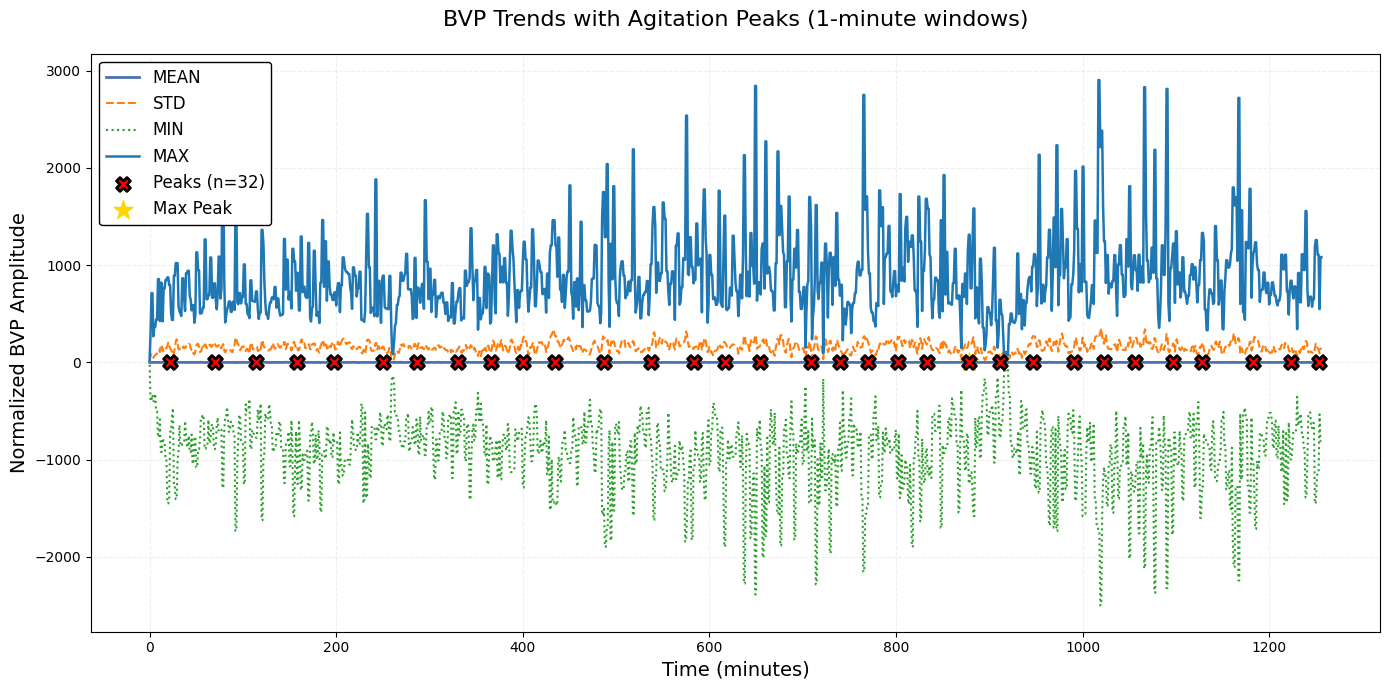


Peak Analysis Summary:
     Time (min)  BVP Value  Peak Prominence
878         878   5.785563         5.785633
709         709   4.656057         4.656127
434         434   4.652135         4.652206
947         947   4.302128         4.302198
617         617   3.530505         3.530575


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load preprocessed feature file
file_path = '/content/drive/My Drive/Agitation_Detection_Project/original_features_test/Participant1_Day1_features.csv'
df = pd.read_csv(file_path)

# ========== BVP TREND PLOTTING ==========
print("\n=== BVP Trend Analysis ===")

# Check if BVP features exist in the dataset
bvp_columns = [col for col in df.columns if col.startswith('bvp_')]
if not bvp_columns:
    raise ValueError("No BVP features found in the dataset")

# Extract relevant BVP features (assuming these are present)
bvp_features = ['bvp_mean', 'bvp_std', 'bvp_min', 'bvp_max']
available_bvp = [f for f in bvp_features if f in df.columns]

if not available_bvp:
    raise ValueError("No standard BVP metrics found in the dataset")

# Create time axis (assuming windows are consecutive 1-minute intervals)
time_minutes = np.arange(len(df))

# Plotting with improved styling
plt.figure(figsize=(14, 7))

# Custom color scheme
colors = {
    'bvp_mean': '#4C72B0',  # Blue
    'bvp_std': '#FF7F0E',   # Orange
    'bvp_min': '#2CA02C',   # Green
    'bvp_max': '#1F77B4'    # Lighter blue
}

# Plot each available BVP feature with custom styling
line_styles = {
    'bvp_mean': '-',
    'bvp_std': '--',
    'bvp_min': ':',
    'bvp_max': '-'
}

line_widths = {
    'bvp_mean': 2,
    'bvp_std': 1.5,
    'bvp_min': 1.5,
    'bvp_max': 1.8
}

for feature in available_bvp:
    plt.plot(time_minutes, df[feature],
             color=colors.get(feature, '#333333'),
             linestyle=line_styles.get(feature, '-'),
             linewidth=line_widths.get(feature, 1),
             label=feature.replace('bvp_', '').upper())

# Find and mark peaks in mean BVP with enhanced visibility
if 'bvp_mean' in df.columns:
    peaks, properties = find_peaks(df['bvp_mean'],
                                  height=np.mean(df['bvp_mean'])*1.1,
                                  distance=30)  # Minimum 30 samples between peaks
    plt.scatter(time_minutes[peaks], df['bvp_mean'].iloc[peaks],
               color='red',
               marker='X',  # Using capital X for better visibility
               s=100,       # Larger marker size
               linewidths=2,
               edgecolors='black',
               zorder=10,   # Ensure peaks appear above other lines
               label=f'Peaks (n={len(peaks)})')

# Highlight the highest peak
if len(peaks) > 0:
    max_peak_idx = peaks[np.argmax(df['bvp_mean'].iloc[peaks])]
    plt.scatter(time_minutes[max_peak_idx], df['bvp_mean'].iloc[max_peak_idx],
               color='gold',
               marker='*',
               s=200,
               label='Max Peak')

# Format plot with professional styling
plt.title('BVP Trends with Agitation Peaks (1-minute windows)', fontsize=16, pad=20)
plt.xlabel('Time (minutes)', fontsize=14)
plt.ylabel('Normalized BVP Amplitude', fontsize=14)
plt.grid(True, alpha=0.2, linestyle='--')

# Custom legend
legend = plt.legend(fontsize=12, framealpha=1)
legend.get_frame().set_edgecolor('black')

plt.tight_layout()

# Show plot
plt.show()

# Print diagnostic information
print("\nPeak Analysis Summary:")
peak_stats = pd.DataFrame({
    'Time (min)': time_minutes[peaks],
    'BVP Value': df['bvp_mean'].iloc[peaks],
    'Peak Prominence': properties['peak_heights'] - np.mean(df['bvp_mean'])
}).sort_values('BVP Value', ascending=False)

print(peak_stats.head(5))

if 'Label' in df.columns:
    print("\nLabel Correlation:")
    print(df[available_bvp + ['Label']].corr()['Label'].sort_values(ascending=False))

# Step 6: Process Features for All the Files

📌 Clean and Format the Files

In [ ]:
import pandas as pd
import os
from tqdm import tqdm

# Directories
input_dir = '/content/drive/My Drive/Agitation_Detection_Project/temp_csvs'
output_dir = '/content/drive/My Drive/Agitation_Detection_Project/original_features_csvs'
os.makedirs(output_dir, exist_ok=True)

# Collect all .csv files
all_csv_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')]
print(f"📁 Found {len(all_csv_files)} '.csv' files in '{input_dir}'")

# Counters
copied_count = 0
skipped_count = 0
failed_count = 0
df_list = []

# Process files
for file in tqdm(all_csv_files, desc="Checking and copying files"):
    base_filename = os.path.basename(file).strip()
    feature_filename = base_filename.replace('.csv', '_features.csv')  # Expected output name

    feature_output_path = os.path.join(output_dir, feature_filename)

    if os.path.exists(feature_output_path):
        print(f"⏩ Skipped (feature file already exists): {feature_filename}")
        skipped_count += 1
        continue

    try:
        df = pd.read_csv(file)
        df.to_csv(feature_output_path, index=False)
        df_list.append(df)
        copied_count += 1
    except Exception as e:
        print(f"❌ Failed to process {base_filename}: {e}")
        failed_count += 1

# Combine newly processed data
if df_list:
    full_df = pd.concat(df_list, ignore_index=True)
    print("✅ Newly processed files loaded:", full_df.shape)
else:
    print("✅ All files were already processed or skipped.")

# Summary
print("\n📊 Summary:")
print(f"✅ Files copied: {copied_count}")
print(f"⏩ Files skipped (already have _features version): {skipped_count}")
print(f"❌ Files failed to process: {failed_count}")
print(f"📁 Total files in output: {len(os.listdir(output_dir))}")

 📌 Load All Feature File

In [ ]:
import pandas as pd
import os

# Directory containing your original feature files
input_dir = '/content/drive/My Drive/Agitation_Detection_Project/original_features_csvs'

# Load all CSV files
all_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')]
df_list = []

for file in all_files:
    try:
        df = pd.read_csv(file)
        df_list.append(df)
    except Exception as e:
        print(f"❌ Failed to load {file}: {e}")

# Combine into one DataFrame
if df_list:
    full_df = pd.concat(df_list, ignore_index=True)
    print("✅ Loaded full_df with shape:", full_df.shape)
else:
    print("⚠️ No files loaded. Check input path and file format.")

✅ Loaded full_df with shape: (560329, 38)


📌 Correlation-Based Reduction

In [ ]:
import numpy as np

# Function to remove highly correlated features
def reduce_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"📉 Dropping {len(to_drop)} highly correlated features.")
    reduced_df = df.drop(columns=to_drop)
    return reduced_df, to_drop

# Select only feature columns (excluding metadata)
exclude_cols = ['start_time', 'end_time', 'participant', 'day', 'label']
feature_cols = [col for col in full_df.columns if col not in exclude_cols]

# Apply reduction
reduced_df, dropped_cols = reduce_features(full_df[feature_cols])

# Reattach metadata
final_df = pd.concat([full_df[exclude_cols], reduced_df], axis=1)
print("✅ Final DataFrame shape after reduction:", final_df.shape)

# Show dropped features
print("🧹 Dropped columns due to high correlation:")
for col in dropped_cols:
    print(f" - {col}")

📉 Dropping 3 highly correlated features.
✅ Final DataFrame shape after reduction: (560329, 35)
🧹 Dropped columns due to high correlation:
 - eda_area
 - bvp_max
 - bvp_total_power


📌 Save the Reduced Feature Set

In [ ]:
import os
from tqdm import tqdm

# 🔧 Step 1: Clean up participant and day values using regex
final_df['participant'] = final_df['participant'].astype(str).str.extract(r'Participant(\d+)', expand=False)
final_df['day'] = final_df['day'].astype(str).str.extract(r'Day(\d+)', expand=False)

# Drop rows with missing IDs (just in case)
final_df.dropna(subset=['participant', 'day'], inplace=True)

# Convert to string format for consistency
final_df['participant'] = final_df['participant'].astype(int).astype(str)
final_df['day'] = final_df['day'].astype(int).astype(str)

# Optional: Sort for neat output
final_df.sort_values(by=['participant', 'day'], inplace=True)

# 📁 Step 2: Set up output directory
output_dir = '/content/drive/My Drive/Agitation_Detection_Project/final_features_csvs'
os.makedirs(output_dir, exist_ok=True)

# Step 3: Group by participant and day
grouped = final_df.groupby(['participant', 'day'])

# Initialize counters
saved_count = 0
skipped_count = 0

print("💾 Saving individual feature files...")

for (participant, day), group_df in tqdm(grouped, desc="Saving files"):
    try:
        filename = f'Participant{participant}_Day{day}_final_features.csv'
        file_path = os.path.join(output_dir, filename)

        if os.path.exists(file_path):
            print(f"⏩ Skipped (already exists): {filename}")
            skipped_count += 1
            continue

        group_df.to_csv(file_path, index=False, encoding='utf-8')
        print(f"✅ Saved: {filename}")
        saved_count += 1

    except Exception as e:
        print(f"❌ Failed to save {filename}: {e}")

# 📊 Summary
print("\n🎉 All files processed.")
print(f"📂 Files saved: {saved_count}")
print(f"⏭️ Files skipped (already existed): {skipped_count}")

💾 Saving individual feature files...


Saving files: 100%|██████████| 435/435 [00:02<00:00, 203.15it/s]

⏩ Skipped (already exists): Participant1_Day1_final_features.csv
⏩ Skipped (already exists): Participant1_Day10_final_features.csv
⏩ Skipped (already exists): Participant1_Day11_final_features.csv
⏩ Skipped (already exists): Participant1_Day12_final_features.csv
⏩ Skipped (already exists): Participant1_Day13_final_features.csv
⏩ Skipped (already exists): Participant1_Day14_final_features.csv
⏩ Skipped (already exists): Participant1_Day15_final_features.csv
⏩ Skipped (already exists): Participant1_Day16_final_features.csv
⏩ Skipped (already exists): Participant1_Day17_final_features.csv
⏩ Skipped (already exists): Participant1_Day18_final_features.csv
⏩ Skipped (already exists): Participant1_Day19_final_features.csv
⏩ Skipped (already exists): Participant1_Day2_final_features.csv
⏩ Skipped (already exists): Participant1_Day20_final_features.csv
⏩ Skipped (already exists): Participant1_Day21_final_features.csv
⏩ Skipped (already exists): Participant1_Day22_final_features.csv
⏩ Skipped (a

# STEP 7: 📊 Visual Exploration of the Reduced Features

📌 Plot Correlation Matrix (Before and After Reduction)

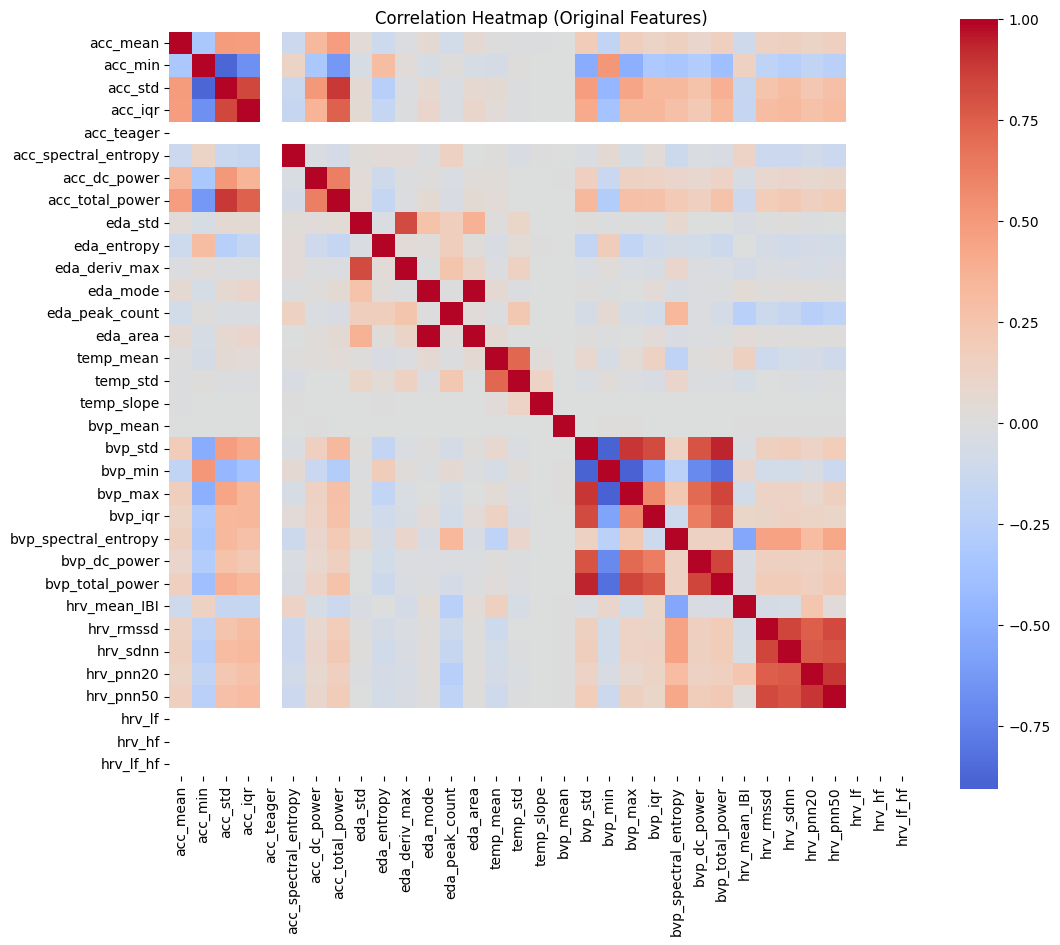

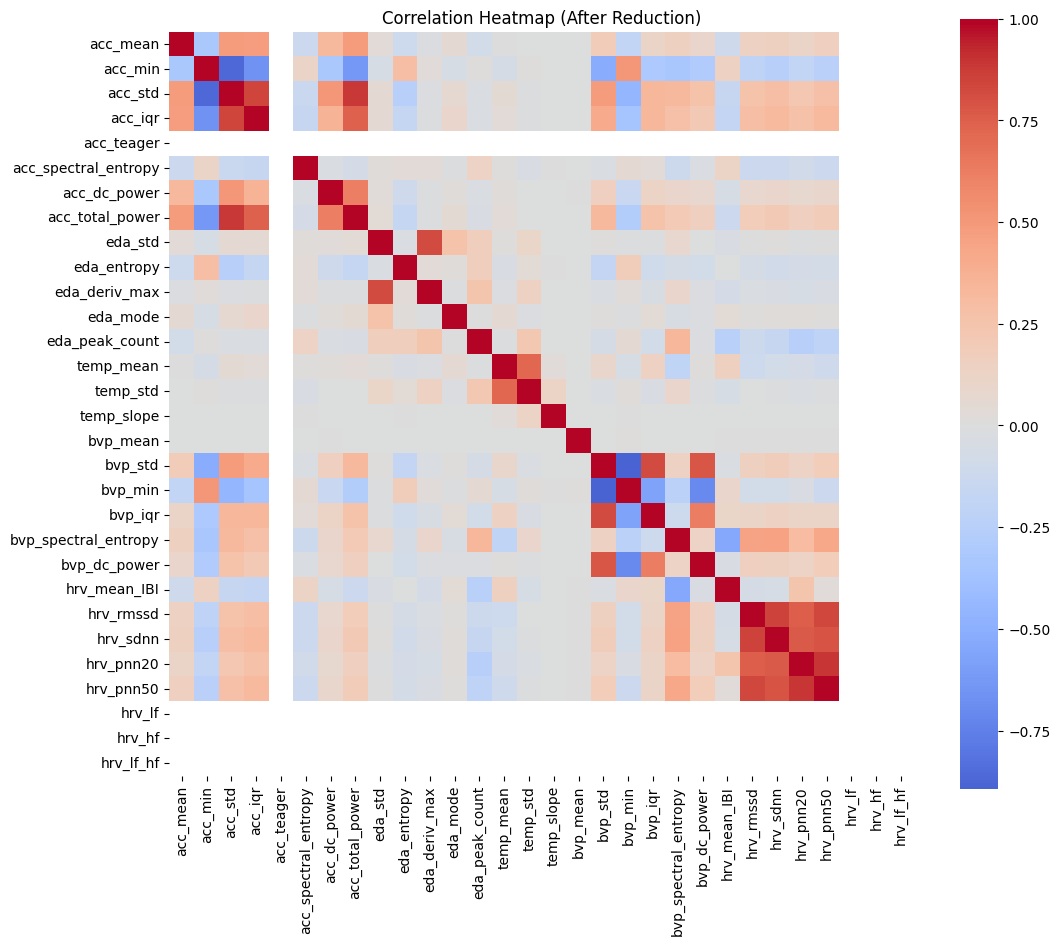

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# For visualization, limit to 40 features if too many
corr_features = feature_cols[:40]

# Correlation heatmap BEFORE reduction
plt.figure(figsize=(12, 10))
sns.heatmap(full_df[corr_features].corr(), cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap (Original Features)")  # Remove 🔎

plt.show()

# Correlation heatmap AFTER reduction
reduced_features = [col for col in reduced_df.columns if col in feature_cols][:40]
plt.figure(figsize=(12, 10))
sns.heatmap(reduced_df[reduced_features].corr(), cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap (After Reduction)")
plt.show()


🔶 Before Reduction:
Clear high correlations in clusters — especially among ACC, BVP, and HRV features.

Features like acc_mean, acc_min, acc_std, and acc_iqr likely contributed to redundancy.

HRV features (e.g., hrv_sdnn, hrv_rmssd, hrv_pnn20, etc.) show high inter-correlations.

🔷 After Reduction: ~35 Features
Redundant clusters are broken down — fewer strong correlations.

Your correlation threshold (0.9) effectively removed highly correlated features.

The reduced feature set is more orthogonal and ready for modeling.



# STEP 8: 📊 Visualizing Distributions and Label Associations

📌 Visualize Feature Distributions (Histograms)

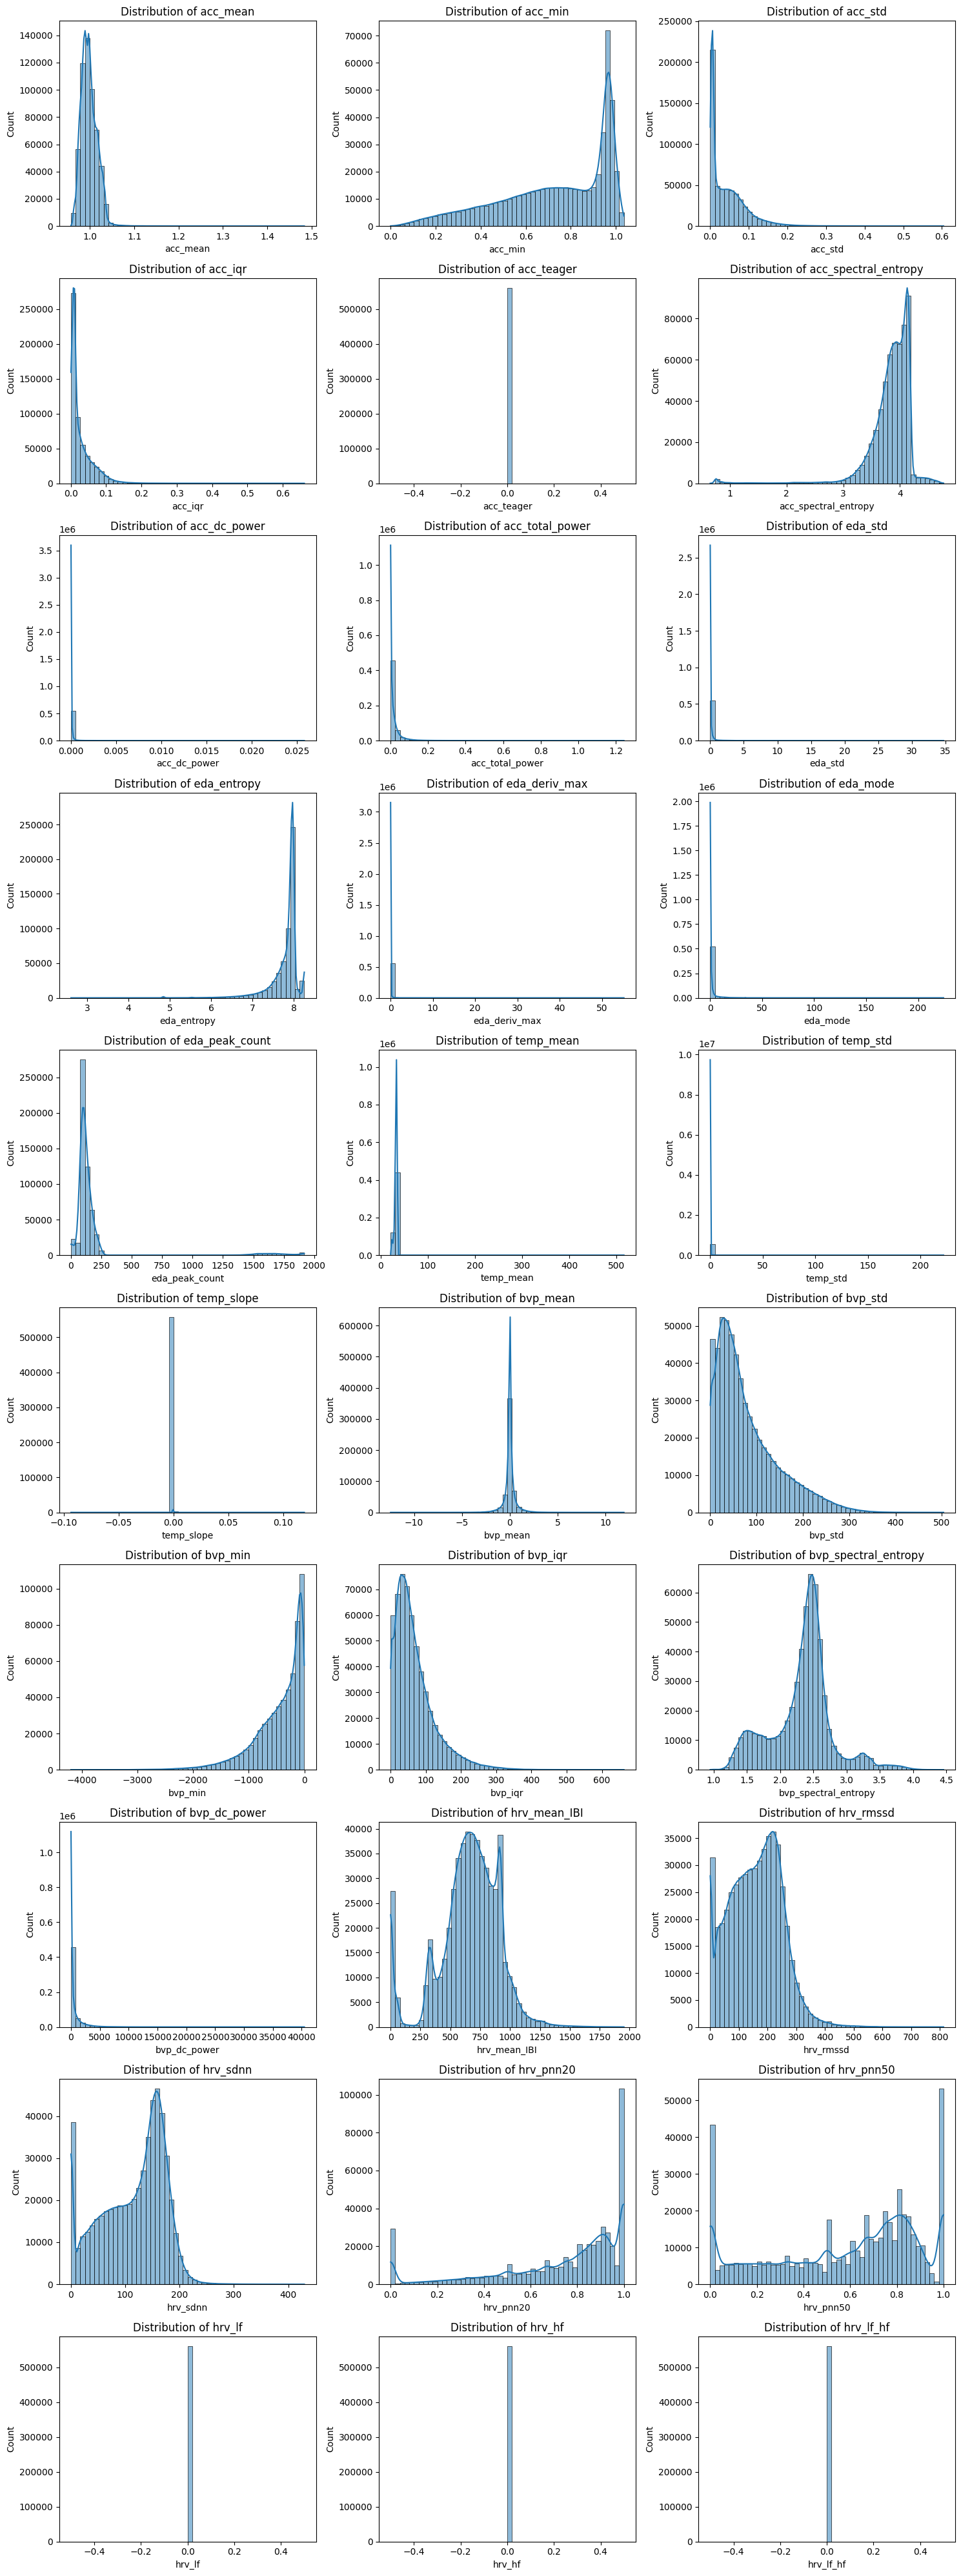

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define how many columns you want per row
num_columns = 3
num_plots = len(reduced_df.columns)  # Total number of features to plot
num_rows = int(np.ceil(num_plots / num_columns))  # Dynamically determine row count

# Create figure and axes with correct grid size
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 4))

# Flatten axes for easier indexing if there are extra slots
axes = axes.flatten()

# Generate histograms for each feature
for i, col in enumerate(reduced_df.columns):
    sns.histplot(reduced_df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Removes empty subplots

plt.tight_layout()  # Optimize spacing
plt.show()

📌 Explore Feature-Label Correlations (Boxplots)

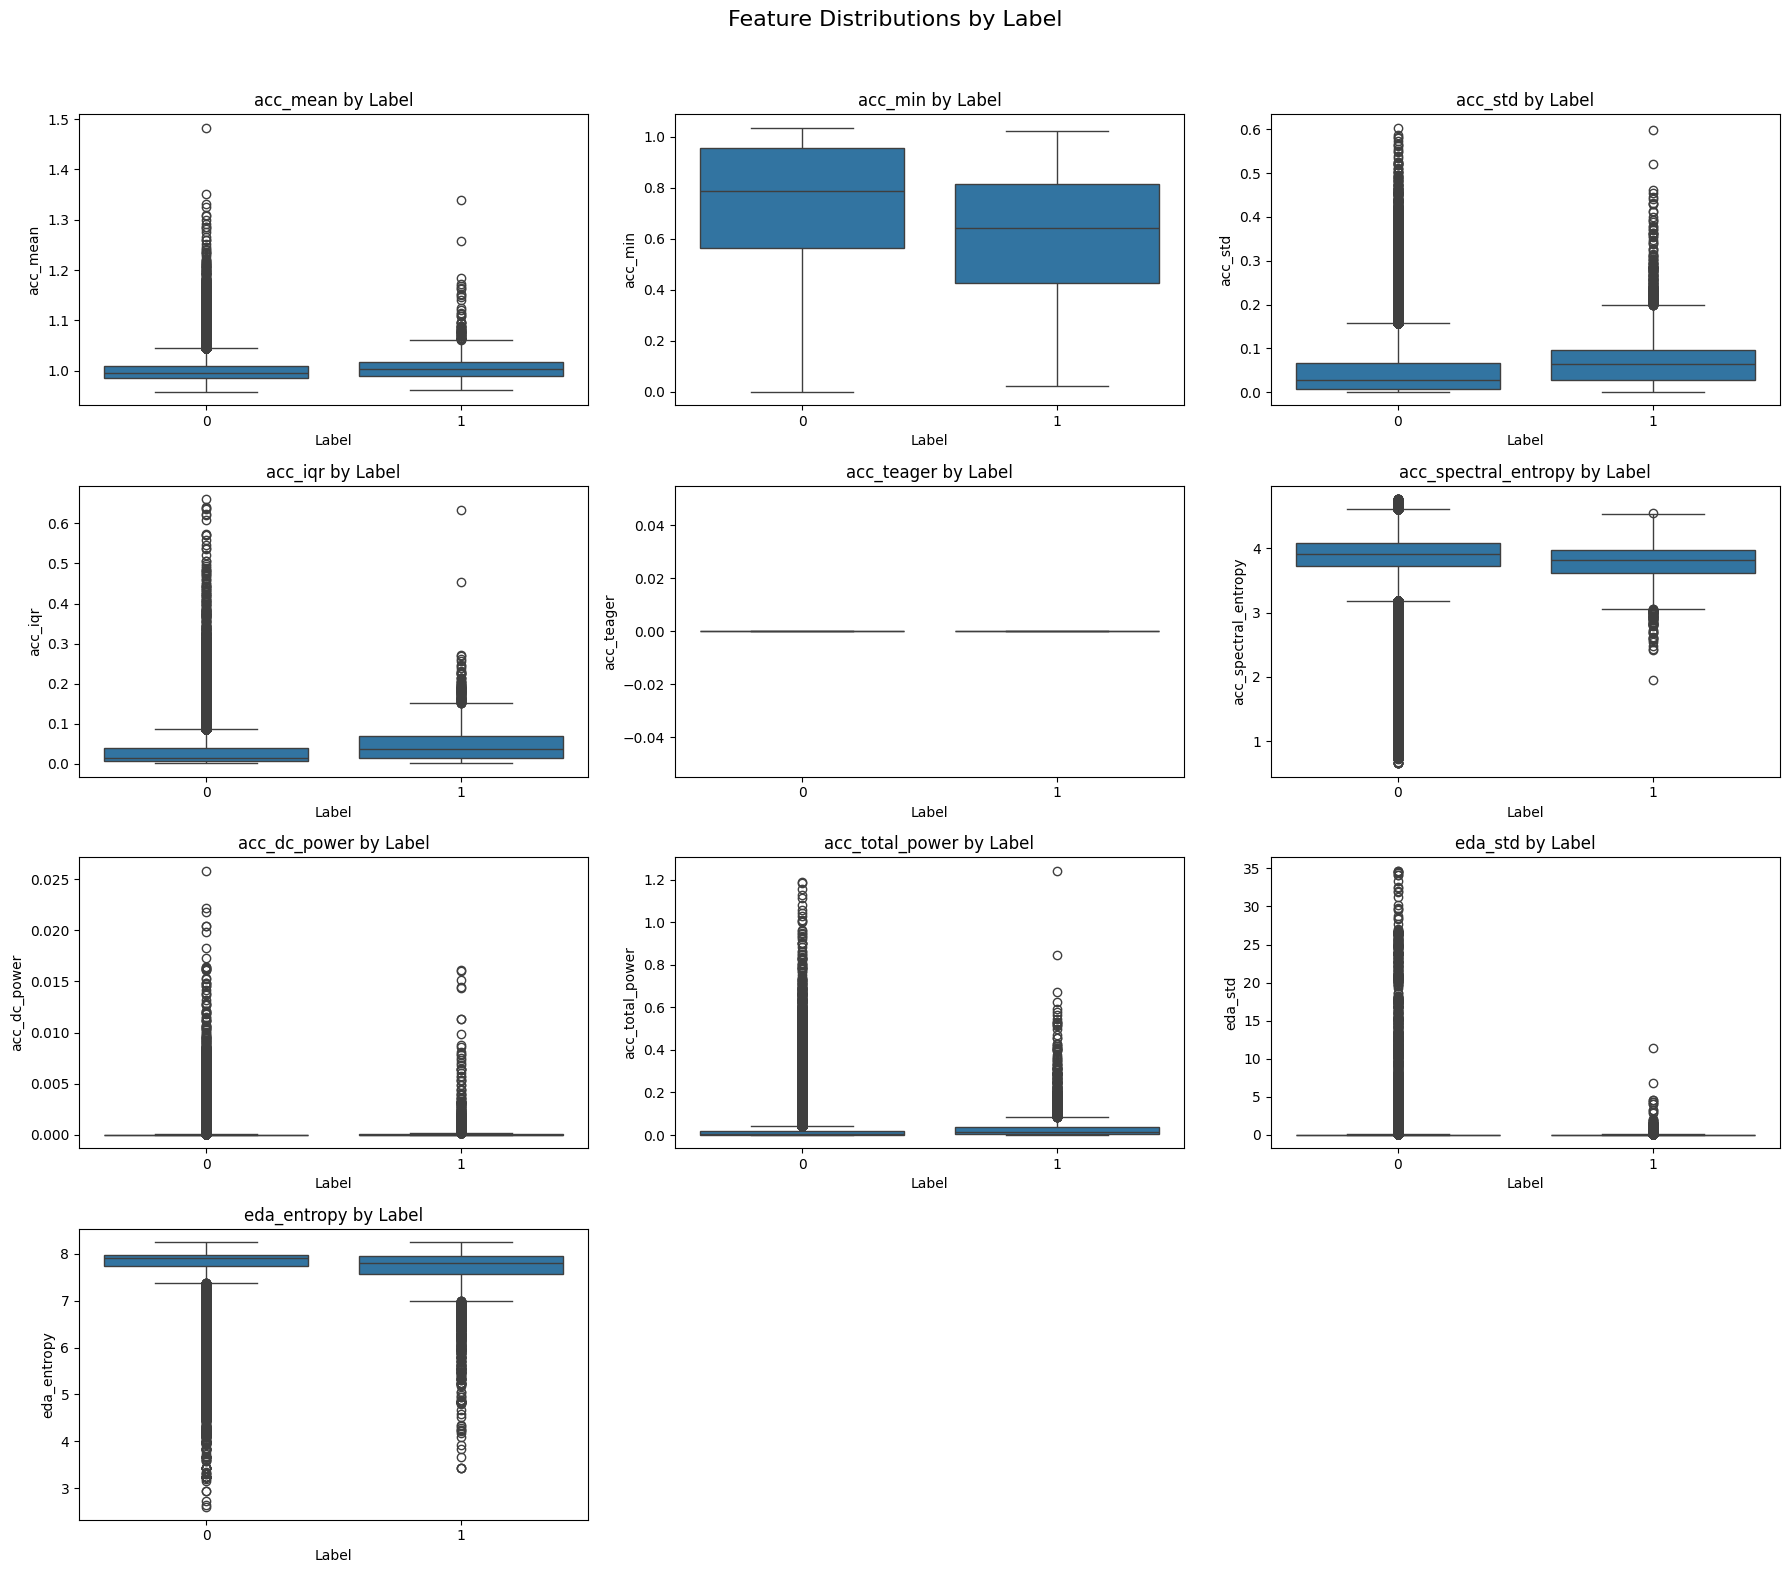

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the first 10 features
selected_cols = reduced_df.columns[:10]

# Set up grid: 3 columns, calculate rows automatically
num_cols = 3
num_rows = int(np.ceil(len(selected_cols) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
fig.suptitle("Feature Distributions by Label", fontsize=16)

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(selected_cols):
    sns.boxplot(x=full_df['label'], y=full_df[col], ax=axes[i])
    axes[i].set_title(f"{col} by Label")
    axes[i].set_xlabel("Label")
    axes[i].set_ylabel(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

📌 Correlation with label


In [ ]:
# Select only numeric columns
numeric_cols = full_df.select_dtypes(include=[np.number]).columns

# Now compute correlation with 'label'
label_corr = full_df[numeric_cols].corr()['label'].sort_values(ascending=False)
print("📈 Correlation with Label:")
print(label_corr)


📈 Correlation with Label:
label                   1.000000
acc_std                 0.062490
acc_iqr                 0.060187
acc_total_power         0.049306
acc_mean                0.038200
acc_dc_power            0.035312
bvp_max                 0.031489
bvp_std                 0.028462
hrv_pnn50               0.027818
hrv_pnn20               0.024131
hrv_rmssd               0.023963
hrv_sdnn                0.023893
bvp_total_power         0.022608
bvp_spectral_entropy    0.019949
bvp_dc_power            0.016445
bvp_iqr                 0.012125
temp_mean               0.005621
bvp_mean                0.000184
temp_slope             -0.000031
temp_std               -0.004959
eda_deriv_max          -0.005259
eda_std                -0.005380
eda_mode               -0.008032
eda_area               -0.008789
hrv_mean_IBI           -0.015781
acc_spectral_entropy   -0.017069
eda_peak_count         -0.026518
bvp_min                -0.031885
eda_entropy            -0.039374
acc_min          